In [1]:
import os,time,sys
import matplotlib.pyplot as plt 
import numpy as np
from charon import propa
from charon import profile
import charon.physicsconstants as PC
pc = PC.PhysicsConstants()
from Spectra_functions import Spectra_generator, Spectra_interpolation, Flux_generator, J_interpolation, Flux_interpolation, Signal_PDF, Background_PDF
from ipynb.fs.full.func_plot_histo import plot_projections

In [2]:
sys.path.append("/home/dvaldenaire/Python/Analysis/DMfit/DMfit")
from modeling import PdfBase, Model, Parameter
from data_DM import DataSet
from llh import LikelihoodRatioTest

Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5


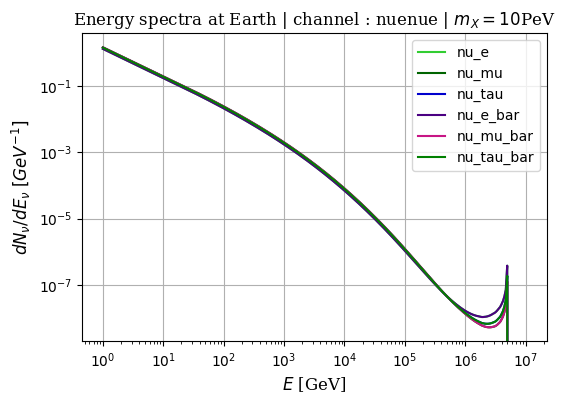

In [3]:
Reco_rate_NFW = Signal_PDF(mass=1e7, channel='nuenue',process='decay',galactic_profile=profile.NFW, extrapolation=True, normalize=True)

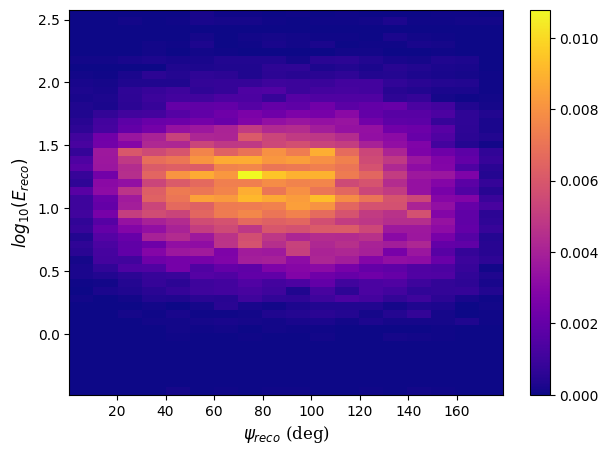

In [4]:
Background = Background_PDF(oversample=True, hist=True, bins=[18,50], density=True)

In [5]:
SignalPDF = PdfBase(Reco_rate_NFW.flatten()/np.sum(Reco_rate_NFW), name='Signal PDF')

In [6]:
BackgndPDF = PdfBase((Background[0].flatten())/np.sum(Background[0]), name='Background PDF')

In [7]:
signal_fit = Parameter(value=0.5, limits=(0,1), fixed=False, name='signal fit')
signal_inj = Parameter(value=0., limits=(0,1), fixed=True, name='signal inj')

In [8]:
modelH1 = signal_fit*SignalPDF + (1-signal_fit)*BackgndPDF
modelH0 = signal_inj*SignalPDF + (1-signal_inj)*BackgndPDF

pseudo_data = signal_inj*SignalPDF + (1-signal_inj)*BackgndPDF
lr = LikelihoodRatioTest(model = modelH1, null_model = pseudo_data)

Parameter signal fit already exists in the model, it won't be added again
Parameter signal inj already exists in the model, it won't be added again
Parameter signal inj already exists in the model, it won't be added again


In [9]:
ds = DataSet()
Background_sample = Background_PDF(oversample=True, hist=False, bins=None, density=None)
ds.sample(len(Background_sample), modelH1)

In [12]:
ksi = np.linspace(0.003,0.010,50)
ds = DataSet()
signal_frac_sample = []
for s in ksi:
    signal_fraction = []
    pseudo_data.parameters["signal inj"].value = s #change the signal injection
    for j in range(200):
        ds.sample(len(Background_sample), pseudo_data)
        lr = LikelihoodRatioTest(model = modelH1, null_model = modelH0)
        lr.data = ds #inject data in the likelihood model
        lr.fit('H1')
        signal_fraction.append(lr.models['H1'].parameters['signal fit'].value)
    signal_frac_sample.append(signal_fraction)

In [13]:
median, percentile68, low98 = [],[],[]
for i in range(len(ksi)):
    median.append(np.median(signal_frac_sample[i]))
    percentile68.append(np.percentile(signal_frac_sample[i],84.1))
    low98.append(np.percentile(signal_frac_sample[i],15.9))

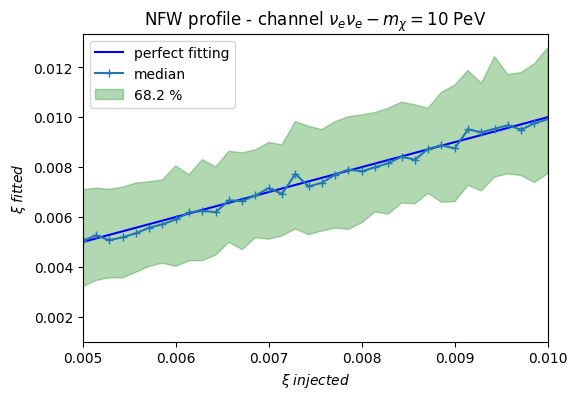

In [25]:
plt.figure(figsize=(6,4))
plt.plot(ksi,ksi,'b-', label = 'perfect fitting')
plt.plot(ksi,median,marker='+',label='median')
plt.xlim(0.005,0.010)
plt.title(r'NFW profile - channel $\nu_e\nu_e - m_\chi = 10$ PeV')
plt.xlabel(r'$\xi \; injected$')
plt.ylabel(r'$\xi \; fitted$')
plt.fill_between(ksi, low98, percentile68, alpha=0.3, color='green', label = '68.2 %')
plt.legend(loc=2)